In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('datasets/train_feature_engineer.csv')

In [3]:
data.shape

(2051, 143)

In [4]:
#create X and y values
X = data.drop('SalePrice',axis=1)
y = data['SalePrice']

#log y values
y = np.log(y)

In [5]:
#repeat previous steps
#create poly features

In [6]:
from sklearn.preprocessing import PolynomialFeatures
poly_convert = PolynomialFeatures(include_bias=False)
X_poly = poly_convert.fit_transform(X)

In [7]:
X_poly.shape

(2051, 10295)

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [9]:
#create pipeline

In [10]:
pipe = Pipeline([('ss',StandardScaler()),('en',ElasticNet())])

In [11]:
#From previous notebook, these are the best parameters

#{'en__alpha': 0.01,
# 'en__l1_ratio': 0.7,
# 'en__max_iter': 10000000,
# 'en__selection': 'random',
# 'en__warm_start': True}

In [12]:
#set pipe params

#search around best hyperparameters

pipe_params = {'en__l1_ratio':[.6,.7,.9,.95],
              'en__selection':['random'], #random so it will run faster
              'en__warm_start':[True], #warm start to run faster
              'en__alpha':[0.01,0.005,0.015],
              'en__max_iter': [10000000]}

In [13]:
model = GridSearchCV(pipe,pipe_params,cv=5,verbose=1,scoring='neg_mean_squared_error')

In [14]:
model.fit(X_poly,y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  7.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('en', ElasticNet())]),
             param_grid={'en__alpha': [0.01, 0.005, 0.015],
                         'en__l1_ratio': [0.6, 0.7, 0.9, 0.95],
                         'en__max_iter': [10000000],
                         'en__selection': ['random'],
                         'en__warm_start': [True]},
             scoring='neg_mean_squared_error', verbose=1)

In [15]:
model.best_params_

{'en__alpha': 0.01,
 'en__l1_ratio': 0.9,
 'en__max_iter': 10000000,
 'en__selection': 'random',
 'en__warm_start': True}

In [16]:
#best params

#{'en__alpha': 0.005,
# 'en__l1_ratio': 0.95,
# 'en__max_iter': 10000000,
# 'en__selection': 'random',
# 'en__warm_start': True}

In [17]:
#save model for future use - in case
from joblib import dump,load
dump(model,'models/pred_model.joblib')

['models/pred_model.joblib']

In [18]:
#Get predictions
predictions = model.predict(X_poly)

In [19]:
X_poly.shape

(2051, 10295)

In [20]:
from sklearn.metrics import mean_squared_error

In [21]:
#RSME score: whole set
np.sqrt(mean_squared_error(np.exp(y),np.exp(predictions)))

20767.395625353634

In [22]:
#RSME LOOKS GOOD

Text(0.5, 1.0, 'Predictions vs Actual y')

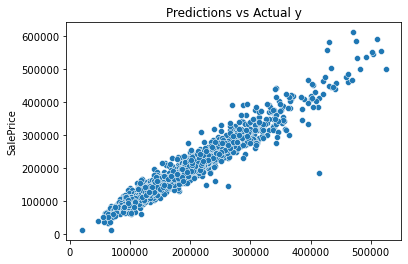

In [23]:
#plot predictions vs actual y
sns.scatterplot(x=np.exp(predictions),y=np.exp(y))
plt.title('Predictions vs Actual y')

In [24]:
#Deploy to test dataset

In [25]:
test_id = pd.read_csv('datasets/test_feature_engineer.csv')

In [26]:
test_id.head()

,Id,MS SubClass,Lot Frontage,Lot Area,Lot Shape,Land Slope,Overall Qual,Overall Cond,Year Built,Year Remod/Add,...,Sale Type_Oth,Sale Type_WD,Mas Vnr Type_CBlock,Exterior 1st_PreCast,Heating_GasA,Exterior 2nd_PreCast,Roof Matl_Roll,Sale Type_VWD,Exterior 2nd_Other,Roof Matl_Metal
0,2658,190,69.0,9142,1,1,6,8,1910,1950,...,0,1,0,0,1,0,0,0,0,0
1,2718,90,0.0,9662,2,1,5,4,1977,1977,...,0,1,0,0,1,0,0,0,0,0
2,2414,60,58.0,17104,2,1,7,5,2006,2006,...,0,0,0,0,1,0,0,0,0,0
3,1989,30,60.0,8520,1,1,5,6,1923,2006,...,0,1,0,0,1,0,0,0,0,0
4,625,20,0.0,9500,2,1,6,5,1963,1963,...,0,1,0,0,1,0,0,0,0,0


In [27]:
test = test_id.drop('Id',axis=1)

In [28]:
from sklearn.preprocessing import PolynomialFeatures
poly_convert = PolynomialFeatures(include_bias=False)
X_poly = poly_convert.fit_transform(test)

In [29]:
final_pred = model.predict(X_poly)

In [30]:
final_pred[:5] #looks ok

array([11.8529158 , 11.92664728, 12.27573383, 11.57495527, 12.05609712])

In [31]:
results = pd.DataFrame(test_id['Id'],columns=['Id'])

In [32]:
results['SalePrice'] = np.exp(final_pred)

In [33]:
results.head()

,Id,SalePrice
0,2658,140493.401555
1,2718,151243.632590
2,2414,214428.971411
3,1989,106399.405236
4,625,172145.807899


In [34]:
results.to_csv('datasets/final.csv',index=False)

In [35]:
results.mean()

Id             1444.749431
SalePrice    174379.837092
dtype: float64

In [36]:
#SUBMIT THIS FILE INTO KAGGLE
#RSME SCORE 26096

In [39]:
testfile = load('models/pred_model.joblib')

In [40]:
en = testfile.best_estimator_.named_steps['en']

In [41]:
en.coef_

array([-0.,  0.,  0., ...,  0.,  0.,  0.])

In [42]:
en.coef_.shape

(10295,)